# Deep Q Networks (DQN) Lab Notebook

In this notebook, you will learn the basics applying the DQN algorithm to simple environments in OpenAI Gym.  By the end of the notebook, you will have a working DQN agent that can balance a CartPole as well as solve other simple control problems in alternate environments.

## Sections

1. <a href=#pix>Getting Started with Pixels to Actions</a>
- <a href=#setup>Setup</a>
- <a href=#dqn>DQN Algorithm</a>
- <a href=#nn>Q-Network model</a>
- <a href=#train>Training</a>

## Requirements
* OpenAI Gym[classic_control] 0.7.4 or higher 
* Python 3.5 or higher
* pyTorch 0.4

Portions of code and explanations in this notebook have been borrowed from the [PyTorch DQN Tutorial by Adam Paszke](https://github.com/apaszke).

# 1. Getting Started with Pixels to Actions<a name='pix' />
In the Q-Learning Lab notebook for this course, you were able to train an agent to balance the OpenAI Gym CartPole using a provided Q-Learning algorithm.  The Q-Learning algorithm read in the environment observations and reward provided by the `gym` CartPole-v0 environment api.  The Q-Learning agent used a table to store all the updated values and simply looked up the best learned value to make decisions.  

This works great when we have an environment that can tell us exactly what is going on.  The CartPole-v0 environment provides the exact position, velocity, and angles of the pole!  But what if all we had was a picture of what was happening in the game?  
<br><br>So instead of an observation like this (position, velocity, angle, tip velocity):

```
observation: [ 0.00326999 -0.17222302  0.01642742  0.30067511]
```

we have an observation like this (the actual image):
<img src="image/cartpole.png?" width="450">




As we've seen in other deep learning problems, a neural network can be trained to "learn" distinguishing features from an image. With a Deep Q-Network (DQN), we can learn to solve the CartPole problem by looking at the scene.  Because of this, our results aren't directly comparable to results that use the simpler observation scheme - this is a much harder task. Training is slower, because all frames have to be rendered.

The algorithm will focus on a patch of the image where the cart exists, and determine the state based on the difference between the current and previous patches. This will allow the agent to take the velocity of the pole into account from one image.

# 2. Setup packages, gpu, utilities<a name='setup' />

In [1]:
# install packages in Udacity Workspaces
# DO NOT EXECUTE OFFLINE
!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

/usr/bin/python: No module named pip


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [2]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


*from the PyTorch tutorial:*<br>
# 3. DQN algorithm<a name='dqn' />

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward

$$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$$

where $R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

$$ \pi^*(s) = \arg\!\max_a \ Q^*(s, a)$$

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

$$Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))$$

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

$$ \delta = Q(s, a) - (r + \gamma \max_a Q(s', a))$$

To minimise this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

$$ \mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)$$


$$   \text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}$$


# 4. Q-network model<a name='nn' />

Our model will be a convolutional neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *quality* of
taking each action given the current input.

### Class: DQN network model

In [3]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### Class: Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Definitions: Input extraction

The code below are utilities for extracting and processing rendered
images from the environment. It uses the ``torchvision`` package, which
makes it easy to compose image transforms. Once you run the cell it will
display an example patch that it extracted.

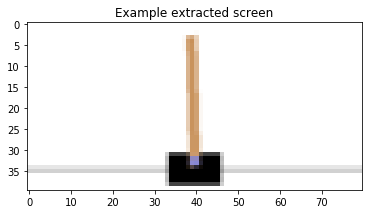

In [6]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()
env.close()

# 5. Training<a name='train' />


## Hyperparameters and utilities

The next two cells set the hyperparameters, instantiate our model and its optimizer, and define two
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.


### Preparation: Instantiate model and optimizer

In [7]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0
episode_durations = []

### Definition: action selection and plot  durations utility

In [8]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)
     
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

### Definition: single step optimization
Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state.

We also use a target network to compute $V(s_{t+1}) for added stability. The target network has its weights kept frozen most of the time, but is updated with the policy network’s weights every so often. This is usually a set number of steps but we shall use episodes for simplicity.


In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

### Definition: main training loop

Below, you can find the main training loop wrapped in the `dqn_training` definition. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

In [10]:
# wrap the main training loop in a definition

def dqn_training(num_episodes, visualize_plt=False, max_steps=500):
    """
    num_episodes: int 
        number of episodes
    visualize_plt: bool
        if true, display the cartpole action in the notebook
        if false (default), display the episodes x durations graph
    """
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        if visualize_plt:
            img = plt.imshow(env.render(mode='rgb_array')) # only call this once, only for jupyter

        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen
        for t in count():
            # Select and perform an action
            action = select_action(state)
            _, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen()
            if visualize_plt:
                img.set_data(env.render(mode='rgb_array')) # just update the data
                plt.axis('off')
                display.display(plt.gcf())
                display.clear_output(wait=True)
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            optimize_model()
            if done or t>max_steps:
                episode_durations.append(t + 1)
                if visualize_plt:
                    print("Duration = {}".format(t))
                else:
                    plot_durations()
                break
        # Update the target network
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    print('Complete')
    env.render(close=True)
    env.close()
    plt.ioff()
    plt.show()

### Execution: Train the model
Below, `num_episodes` is set small. You can run this cell over an over to increase training.  The durations graph shows the duration of the cartpole balance for each episode. 

In [11]:
# note that the duplicate %matplotlib backend call is needed to avoid duplicate graphs
%matplotlib
%matplotlib    
num_episodes=5
dqn_training(num_episodes)

ImportError: No module named '_tkinter', please install the python3-tk package

### Execution: CartPole visualization
Execute the following cell at any point to watch the trained DQN agent control the Cartpole.

In [ ]:
%matplotlib inline
num_episodes=1
dqn_training(num_episodes, visualize_plt=True)